In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib
from scipy.ndimage import gaussian_filter1d

import get_model

In [2]:
path = '/Users/sfdavis/projects/CO/Maxito/'
plot = 0
coplus = 0

In [14]:
redshift  = 0.001826
list_of_spectra = ['entire_spectral_sequence/flux_calibrated/SN2016adj_20160521_BAA_NIR.txtdered.fits.txt']

phase = np.array([530.60])-431.3#since b max

list_of_spectra

['entire_spectral_sequence/flux_calibrated/SN2016adj_20160521_BAA_NIR.txtdered.fits.txt']

In [11]:
num = 0
spec = list_of_spectra[num]
specPhase = phase[num]

spec=pd.read_csv(spec,delimiter='\s+',header=None)
    
if spec.shape[1] == 2:
    spec.columns = ['lambda','flux']  
if spec.shape[1] == 3:   
    spec.columns = ['lambda','flux','err']
if spec['lambda'].values[10] > 1000:
    spec['lambda'] = spec['lambda']/1e4
spec['lambda'] = spec['lambda']/(1+redshift)
spec = spec[(spec['lambda']>2.2)]

# data scaling
upper, lower = 2.20, 2.25
if coplus: upper, lower = 2.20, 2.25
w = np.argmin(abs(np.array(spec['lambda'])-upper))
v = np.argmin(abs(np.array(spec['lambda'])-lower))
integ0 = np.trapz(spec['flux'][w:v],spec['lambda'][w:v])
off = 0.05/integ0
q = [(spec['lambda'] >= 2.25) & (spec['lambda'] <= 2.3)][0]
spec['flux'] = np.array(spec['flux'])*off
spec['flux'] = spec['flux'] - np.min(spec['flux'][q])

In [12]:
df = pd.read_csv('Hoeflich_models.csv')
df = df[(df.molecule == 'CO')]

df = df[(df.mole_frac==0.1)] 
df

,filename,dataset,mole_frac,temperature,n,velocity,molecule
64,plot.dat_5000_3_0.1_CO,3,0.1,5000.0,1.000000e+07,5000,CO
65,plot.dat_5000_3_0.1_CO,3,0.1,5000.0,1.000000e+08,5000,CO
66,plot.dat_5000_3_0.1_CO,3,0.1,5000.0,1.000000e+09,5000,CO
67,plot.dat_5000_3_0.1_CO,3,0.1,5000.0,1.000000e+11,5000,CO
68,plot.dat_5000_3_0.1_CO,3,0.1,4000.0,1.000000e+07,5000,CO
...,...,...,...,...,...,...,...
2363,plot.dat_2000_3_0.1_CO,3,0.1,1750.0,1.000000e+11,2000,CO
2364,plot.dat_2000_3_0.1_CO,3,0.1,1500.0,1.000000e+07,2000,CO
2365,plot.dat_2000_3_0.1_CO,3,0.1,1500.0,1.000000e+08,2000,CO
2366,plot.dat_2000_3_0.1_CO,3,0.1,1500.0,1.000000e+09,2000,CO


16.4% done.
32.9% done.
49.3% done.
65.8% done.
82.2% done.
98.7% done.


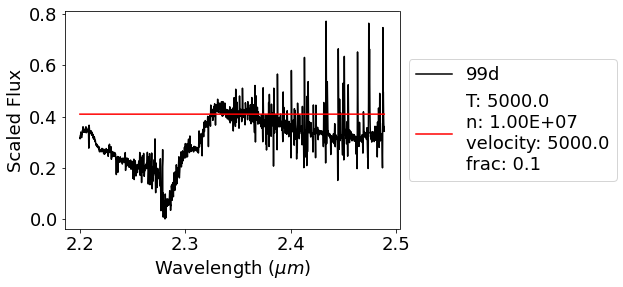

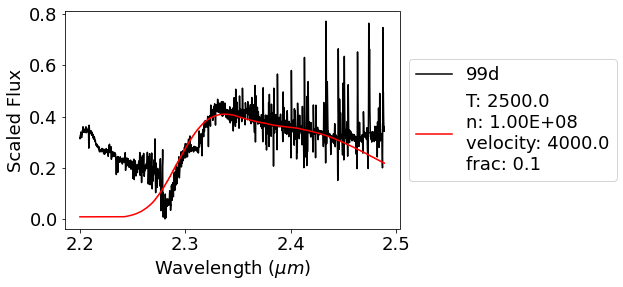

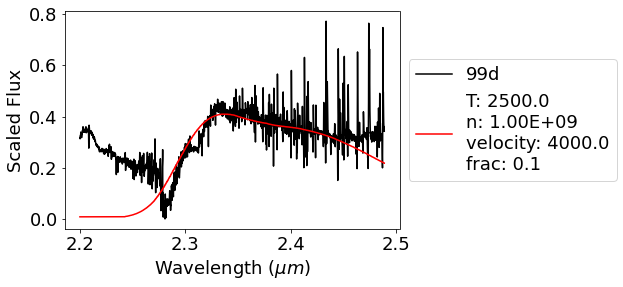

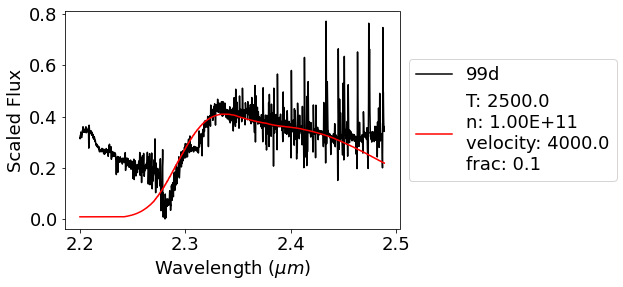

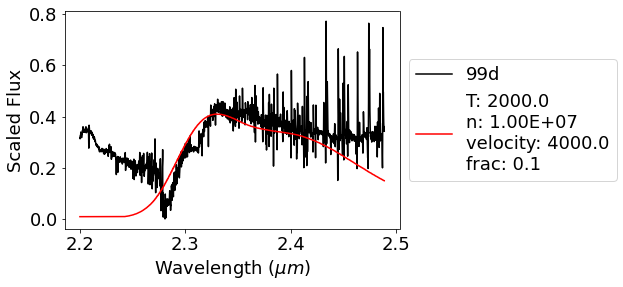

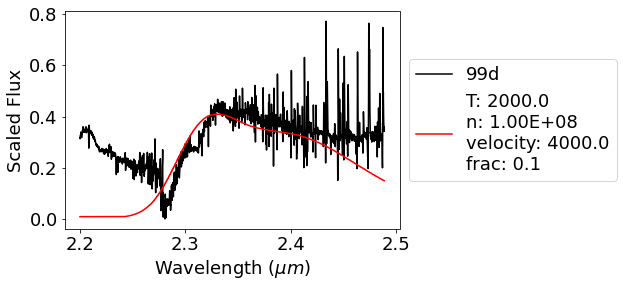

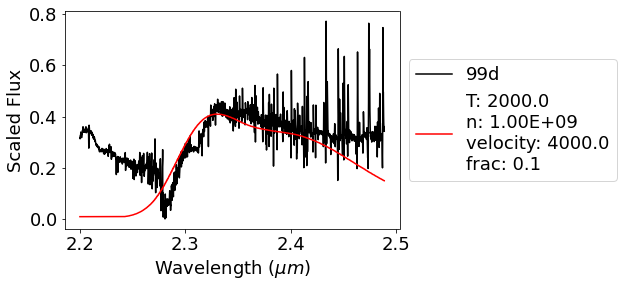

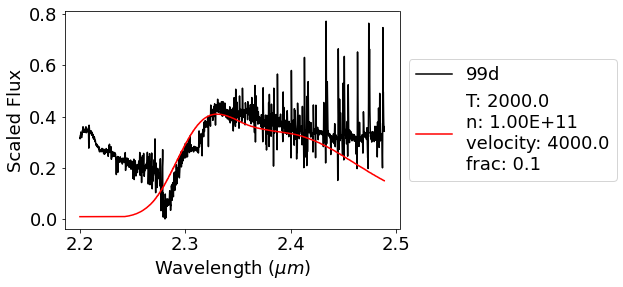

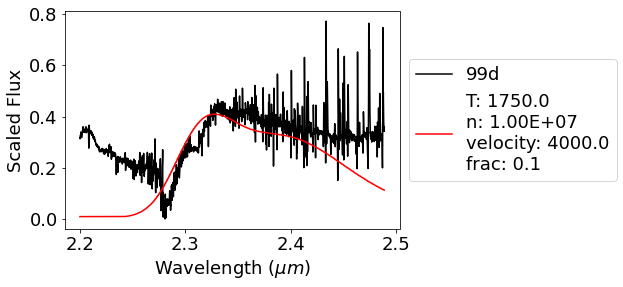

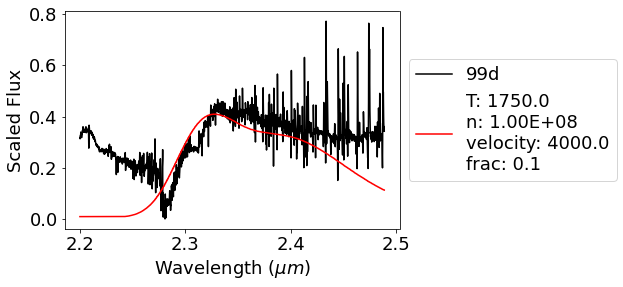

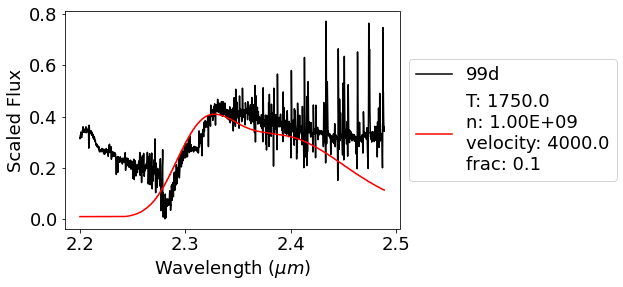

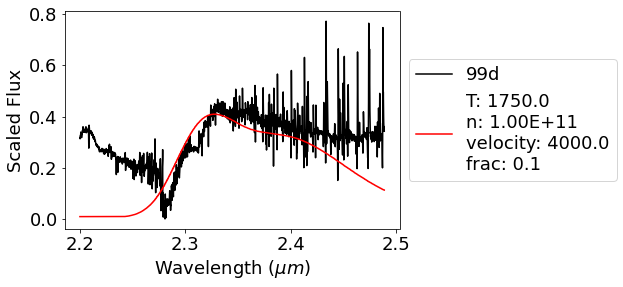

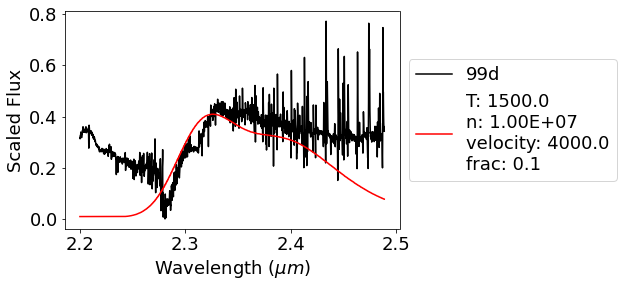

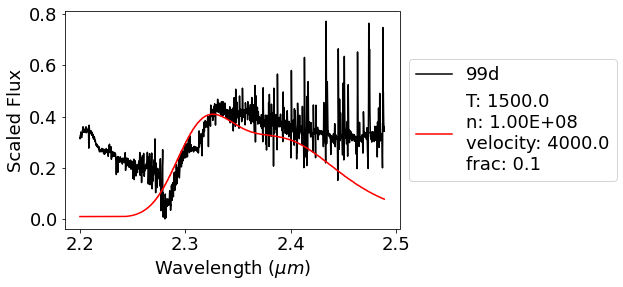

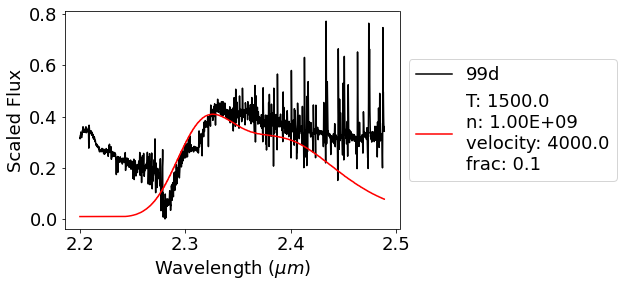

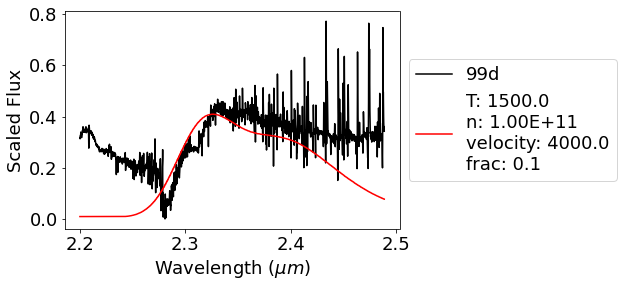

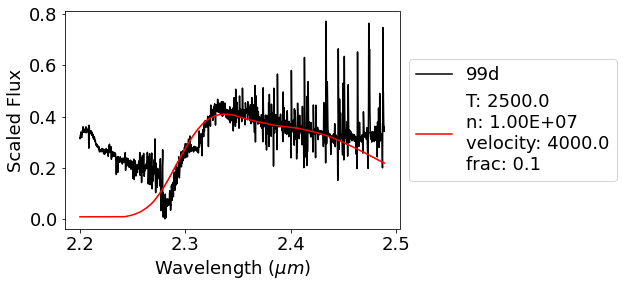

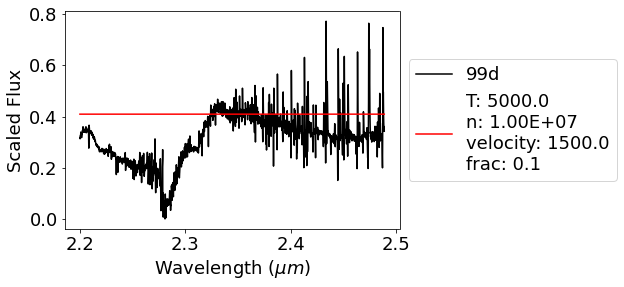

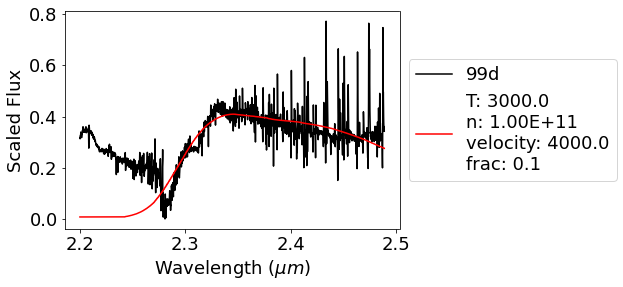

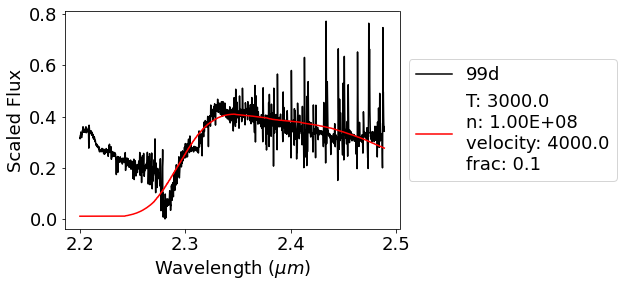

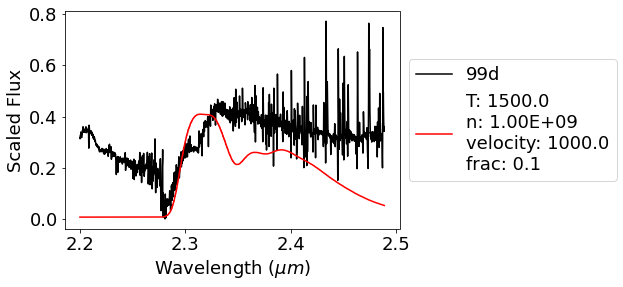

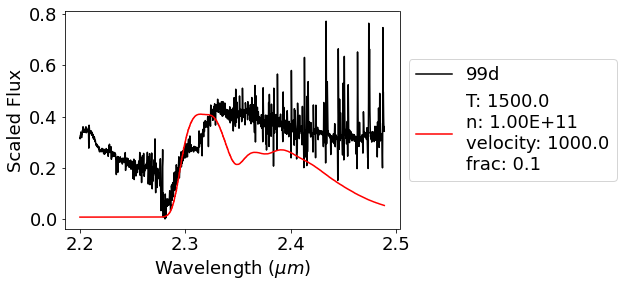

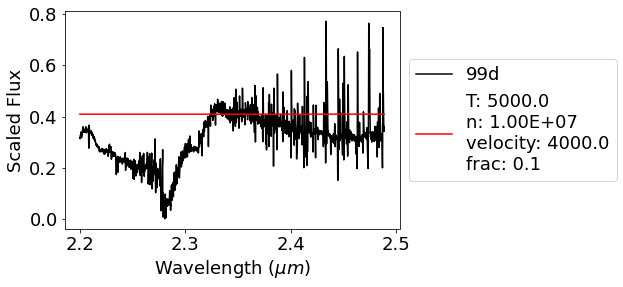

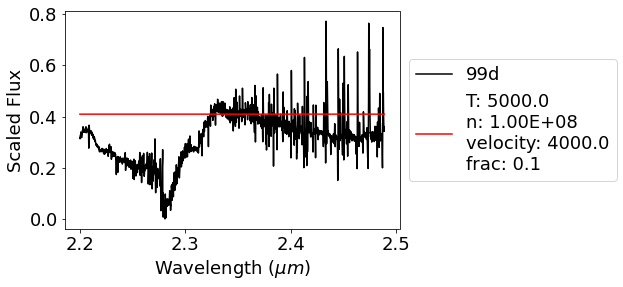

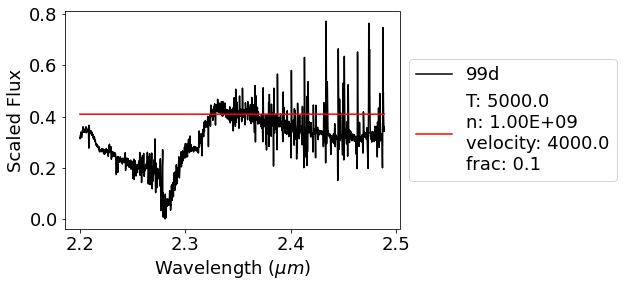

In [13]:
####################################################################
#   Using the new csv files instead of peter's file, much faster   #
####################################################################

# spec 0 has no CO
# all other good fits except 4, which still isn't terrible 
# there is an issue with some 4 and 5k temp models where they are just a straight line
# injest the new spectra and see what happens <- still works

# yolo
import warnings
warnings.filterwarnings("ignore")

def get_model_new(path,temp,n,velocity,mole_frac,molecule):
    modeldf = pd.read_csv(path+'/models_csv/'+
                          molecule+'_'+str(velocity)+'_'+str(mole_frac)+'.csv')

    n = str(format(n, "10.2E")).strip()
    temp = str(format(temp, ".2f")).strip()

    return [modeldf['wl'].values, modeldf[n+'/'+temp].values]

# loop over models
chisq, fArr, fileArr, params = [], [], [], []
for i in range(len(df)):
    if i%100 == 0 and i != 0: 
        print(str(round(i/len(df)*100,1))+'% done.')
        
    # get model from csv file
    wav, opac = get_model.get_csv(path+'/models_csv/',df.temperature.values[i],
                                  df.n.values[i],df.velocity.values[i],
                                  df.mole_frac.values[i],df.molecule.values[i])
    wav = wav/1e4
    
    # trim model
    w = np.where(wav >= 2.2)
    wav, opac = np.array(wav[w]), np.array(opac[w])
    
    # model scaling
    w = np.argmin(abs(wav-upper))
    v = np.argmin(abs(wav-lower))
    #integ = 0.975 + np.trapz(opac[w:v],wav[w:v])
    #integ = 0.8 + np.trapz(opac[w:v],wav[w:v])
    #q = [(spec['lambda'] >= 2.25) & (spec['lambda'] <= 2.3)][0]
    q = [(spec['lambda'] >= 2.20) & (spec['lambda'] <= 2.25)][0]
    integ = np.min(spec['flux'][q]) + np.trapz(opac[w:v],wav[w:v])
    opac = opac + integ
    interpF = np.interp(spec['lambda'],wav,opac) # interpolating to same x
    # scaling the model to match the data since the amount of CO is a free parameter
    w = [(spec['lambda'] >= 2.34)&(spec['lambda'] <= 2.35)][0]
    interpF = interpF*np.median(spec['flux'][w])/np.max(interpF)
    #interpF = interpF*max(spec['flux'][w])/max(interpF)
    
    if plot:
        plt.plot(spec['lambda'],spec['flux'],color='black')
        plt.plot(spec['lambda'],interpF,color='red')
        plt.show()
        
    w = [(spec['lambda'] >= 2.28) & (spec['lambda'] <= 2.46)][0]
    chisq.append(stats.chisquare(interpF[w],spec['flux'].values[w])[0])
    fArr.append(interpF)
    fileArr.append(i)
    params.append([df.temperature.values[i],df.n.values[i],df.velocity.values[i],df.mole_frac.values[i]])
    
w = np.argsort(chisq)
chisq, fArr, fileArr, params = np.array(chisq)[w], np.array(fArr)[w], np.array(fileArr)[w], np.array(params)[w]

# plot best XX models for each spectrum
matplotlib.rcParams.update({'font.size': 18})
for i in range(25):
    label = r'T: '+str(params[i][0])+'\n'+'n: '+format(params[i][1],".2E")+'\n'+\
             'velocity: '+str(params[i][2])+'\n'+'frac: '+str(params[i][3])
    
    w = [(spec['lambda'].values<2.5)]
    plt.plot(spec['lambda'].values[w],spec['flux'].values[w],color='black')
    plt.plot(spec['lambda'].values[w],fArr[i][w],color='red',label=label)
    
    q = [(spec['lambda'].values > 2.2) & (spec['lambda'].values < 2.5)]
    plt.xlabel(r'Wavelength ($\mu m$)')
    plt.ylabel('Scaled Flux')
    plt.legend(bbox_to_anchor=(1.0,0.5), loc="center left",labels=[str(int(specPhase))+'d',label])
    #plt.savefig('/Users/sfdavis/projects/CO/Maxito/fit_plots/'+str(int(params[i][0]))+'_'+
    #            str(format(params[i][1],".0E"))+'_'+str(params[i][2])+'_'+str(params[i][3])'.png',
    #            format='png',dpi=300)
    plt.show()